In [2]:
import pandas as pd
import os
import requests
import numpy as np

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

In [4]:
from preprocessing_utils import preprocess_NVD_data

In [5]:
data_path = 'data'
if not os.path.exists(data_path):
    os.makedirs(data_path)

# EPSS data

Source: EPSS data from https://www.first.org/epss/data_stats (downloaded into `data` folder)

In [6]:
epss_current = pd.read_csv(os.path.join(data_path, 'epss_scores-2025-10-01.csv.gz'), compression='gzip', header=1)
epss_current # a Python statement with a variable name at the end of a cell will display its contents below


,cve,epss,percentile
0,CVE-1999-0001,0.01141,0.77780
1,CVE-1999-0002,0.10742,0.93087
2,CVE-1999-0003,0.90362,0.99589
3,CVE-1999-0004,0.03215,0.86596
4,CVE-1999-0005,0.25334,0.96035
...,...,...,...
296328,CVE-2025-9994,0.00060,0.19138
296329,CVE-2025-9996,0.00179,0.40027
296330,CVE-2025-9997,0.00182,0.40386
296331,CVE-2025-9998,0.00023,0.04753


these are the past data, for comparison

In [7]:
epss_old = pd.read_csv(os.path.join(
    data_path, 'epss_scores-2025-09-30.csv.gz'), compression='gzip', header=1)


# NVD data
Query the official API of the National Vulnerability Database (NVD) to collect all vulnerabilities published between September 1 and October 1, 2025.
The goal is to retrieve all CVEs (Common Vulnerabilities and Exposures) published in a given time interval, managing the pagination of the results.

In [8]:
base_url = "https://services.nvd.nist.gov/rest/json/cves/2.0"
date_start_NVD = '2025-09-01T00:00:00.000Z' # Do NOT change these dates
date_end_NVD   = '2025-10-01T00:00:00.000Z' # Do NOT change these dates
start_index = 0
results_per_page = 1000
total_results = 1 

all_cves = []

while start_index < total_results:
    params = {
        "pubStartDate": date_start_NVD,
        "pubEndDate": date_end_NVD,
        "resultsPerPage": results_per_page,
        "startIndex": start_index,
        "noRejected": ""
    }
    response = requests.get(base_url, params=params, timeout=6)
    if response.status_code != 200:
        print("Error:", response.status_code)
        break

    data = response.json()
    total_results = data.get("totalResults", 0)

    all_cves.extend(data.get("vulnerabilities", []))

    start_index += results_per_page
    print(start_index)

1000
2000
3000
4000
5000


`pd.json_normalize(...)`: converts the list of JSON dictionaries (all_cves) into a tabular DataFrame, flattening the nested structures.
`preprocess_NVD_data(...)`:
- Convert date fields
- Extract the English description, CVSS data, vulnerable CPEs, CWEs, and number of references
- Drop raw columns that are no longer needed

`df.merge()`:
Merges the NVD data with the EPSS data:
- left_on="cve.id": CVE key in the NVD DataFrame
- right_on="cve": CVE key in the EPSS DataFrame (epss_current)
- how="left": keeps all NVD rows, adding EPSS data where available

EPSS provides the probability that a vulnerability will be exploited, which is useful for risk prioritization.

In [10]:
# normalize and preprocess data
df = pd.json_normalize(all_cves, record_path=None, sep='.', max_level=None)
df = preprocess_NVD_data(df)

# remove vulnerabilities marked as "reject" or "reserved"
df = df[(df['cve.vulnStatus'] != 'Reserved') & (df['cve.vulnStatus'] != 'Reject')]

epss_current = epss_current.rename(columns={
    "epss": "epss_current",
    "percentile": "percentile_current"
})
epss_old = epss_old.rename(columns={
    "epss": "epss_old",
    "percentile": "percentile_old"
})


# merge NVD and EPSS data
df = df.merge(epss_current, left_on="cve.id", right_on="cve", how="left")
df = df.merge(epss_old, left_on='cve.id', right_on='cve', how='left')


In [317]:
# save nvd data
with open(os.path.join(data_path, "nvd_cves.json"), "w", encoding="utf-8") as f:
    json.dump(all_cves, f, indent=2)
    
# save the final dataframe
df.to_csv(os.path.join(data_path, "vuln_2025_10.csv"))

# Exploratory Data Analysis

In [11]:
print(df.columns)


Index(['cve.id', 'cve.sourceIdentifier', 'cve.published', 'cve.lastModified',
       'cve.vulnStatus', 'cve.references', 'cve.cisaExploitAdd',
       'cve.cisaActionDue', 'cve.cisaRequiredAction',
       'cve.cisaVulnerabilityName', 'description', 'vulnerable_cpes',
       'num_references', 'cwe_list', 'cvss_version', 'cvss_vectorString',
       'cvss_baseScore', 'cvss_baseSeverity', 'cvss_attackVector',
       'cvss_attackComplexity', 'cvss_privilegesRequired',
       'cvss_userInteraction', 'cvss_scope', 'cvss_confidentialityImpact',
       'cvss_integrityImpact', 'cvss_availabilityImpact', 'cve_x',
       'epss_current', 'percentile_current', 'cve_y', 'epss_old',
       'percentile_old'],
      dtype='object')


Compute the number of CVEs published per day and visualize their temporal distribution to highlight peaks and trends in vulnerability disclosure activity.

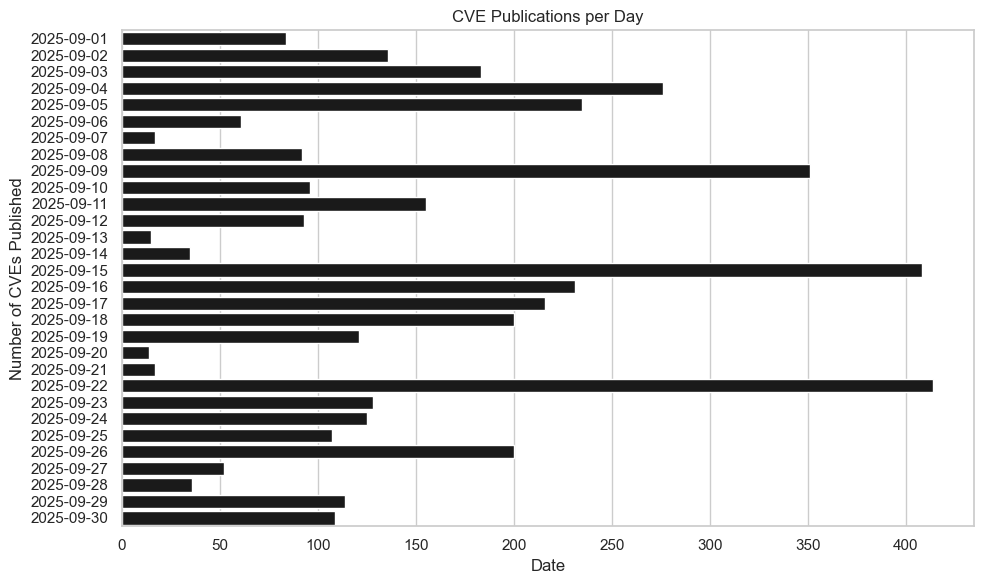

In [13]:
published_counts = df["cve.published"].dt.date.value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=published_counts.values, y=published_counts.index, color="k")
plt.xlabel("Date")
plt.ylabel("Number of CVEs Published")
plt.title("CVE Publications per Day")
plt.tight_layout()
plt.show()


- display some examples (e.g., the first two CVE records)

In [14]:
df.head(2).T

,0,1
cve.id,CVE-2025-9751,CVE-2025-9752
cve.sourceIdentifier,cna@vuldb.com,cna@vuldb.com
cve.published,2025-09-01 00:15:34.580000,2025-09-01 01:15:46.817000
cve.lastModified,2025-09-08 14:06:05.217000,2025-09-04 18:47:25.440000
cve.vulnStatus,Analyzed,Analyzed
cve.references,[{'url': 'https://github.com/HAO-RAY/HCR-CVE/i...,[{'url': 'https://github.com/i-Corner/cve/issu...
cve.cisaExploitAdd,NaN,NaN
cve.cisaActionDue,NaN,NaN
cve.cisaRequiredAction,NaN,NaN
cve.cisaVulnerabilityName,NaN,NaN


- show a bar plot with the daily volume of published CVEs

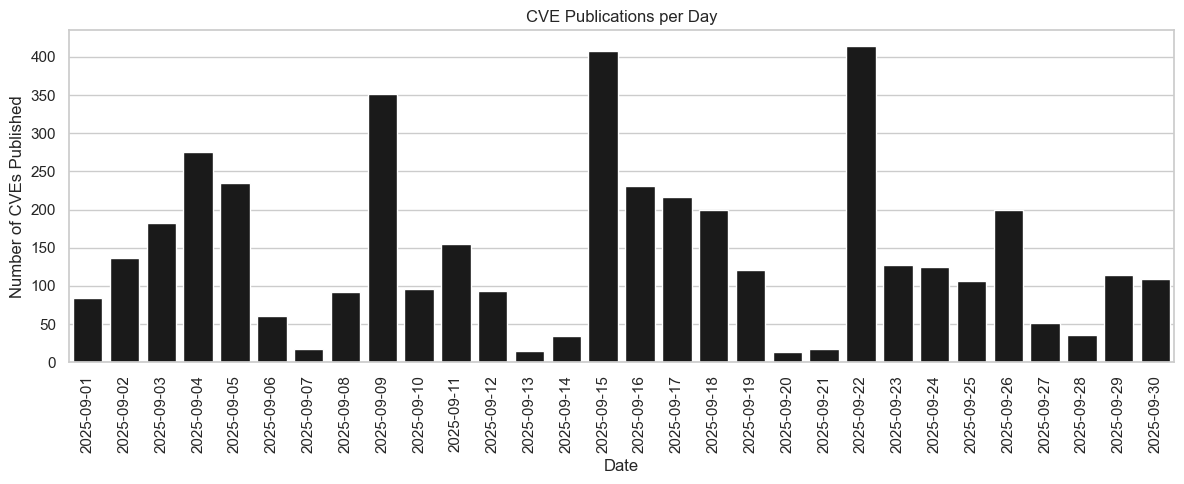

In [15]:
published_counts = df["cve.published"].dt.date.value_counts().sort_index()

plt.figure(figsize=(12, 5))
sns.barplot(x=published_counts.index, y=published_counts.values, color="k" )
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Number of CVEs Published")
plt.title("CVE Publications per Day")
plt.tight_layout()
plt.show()

- print the description of the last ten published vulnerabilities

df.iterrows() restituisce un generatore che produce:  
    - idx: l’indice della riga (può essere numerico o un valore personalizzato)  
    - x: la riga stessa, rappresentata come una Serie Pandas

In [16]:
for idx, x in enumerate(df.sort_values('cve.published', ascending=False)[:10].iterrows()):
    print('-'*100)
    print(x[1]['cve.id'], x[1]['cve.published'])
    print(x[1].description)


----------------------------------------------------------------------------------------------------
CVE-2025-61792 2025-09-30 23:15:29.700000
Quadient DS-700 iQ devices through 2025-09-30 might have a race condition during the quick clicking of (in order) the Question Mark button, the Help Button, the About button, and the Help Button, leading to a transition out of kiosk mode into local administrative access. NOTE: the reporter indicates that the "behavior was observed sporadically" during "limited time on the client site," making it not "possible to gain more information about the specific kiosk mode crashing issue," and the only conclusion was "there appears to be some form of race condition." Accordingly, there can be doubt that a reproducible cybersecurity vulnerability was identified; sporadic software crashes can also be caused by a hardware fault on a single device (for example, transient RAM errors). The reporter also describes a variety of other issues, including initial acc

### What is the percentage of CVEs which received a CVSS score?

In [18]:
total_cves = len(df)
scored_cves = df["cvss_baseScore"].notna().sum()
percentage = (scored_cves / total_cves) * 100
print(f"Percentage of CVEs with CVSS score: {percentage:.2f}%")

Percentage of CVEs with CVSS score: 94.47%


Nearly all CVEs include a CVSS base score, showing that enough technical information was available to perform an initial severity assessment. This indicates that, even at the time of disclosure, most vulnerabilities are described with a level of detail sufficient to support a reliable technical evaluation.

### Report descriptive statistics of CVSS the CVSS base score and/or show its distribution
The CVSS base scores range from 0 to 10, with a mean value of 6.47 and a standard deviation of 2.11.
The distribution is slightly skewed towards higher values, indicating that most vulnerabilities are classified as High or Critical severity

In [20]:
# Consider only the numerical values of CVSS
scores = df["cvss_baseScore"].dropna().astype(float)
stats = scores.describe()
print(stats)

count    4082.000000
mean        6.767442
std         1.726394
min         2.200000
25%         5.500000
50%         6.500000
75%         7.800000
max        10.000000
Name: cvss_baseScore, dtype: float64


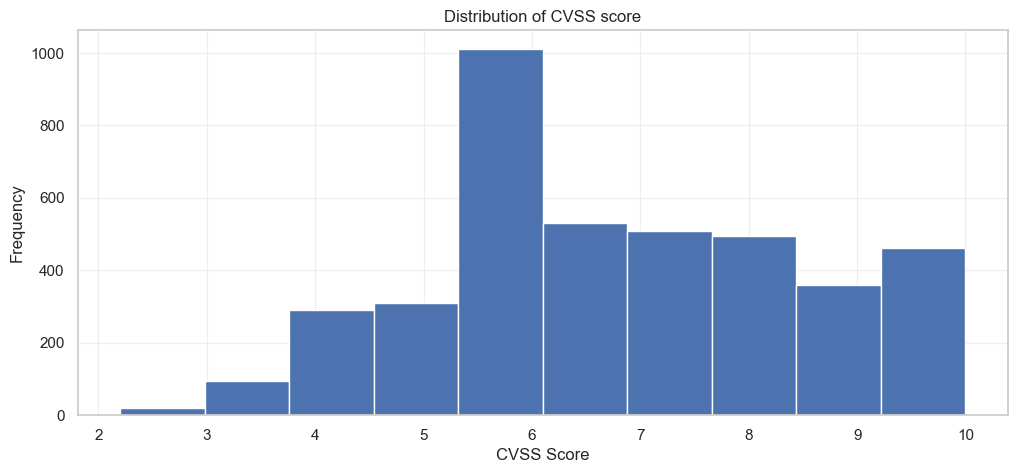

In [21]:
cvsss = df[df["cvss_baseScore"].notna()]
plt.figure(figsize=(12, 5))
plt.title("Distribution of CVSS score")
plt.hist(cvsss["cvss_baseScore"])
plt.ylabel("Frequency")
plt.xlabel("CVSS Score")
plt.grid(alpha=0.3)

plt.show()


### CVSS Severity Classification

The CVSS scores were classified into severity categories using the standard thresholds: **Low (<4.0)**, **Medium (4.0–6.9)**, **High (7.0–8.9)**, and **Critical (≥9.0)**.  

The distribution of vulnerabilities by severity is as follows:

- **Medium:** ~48.5% of vulnerabilities, representing the largest group.  
- **High:** ~33.2%, indicating a substantial portion of issues with significant impact.  
- **Critical:** ~14.8%, the most severe vulnerabilities, requiring immediate attention.  
- **Low:** ~3.6%, the least frequent, suggesting that minor vulnerabilities are rare in this dataset.  

Overall, the distribution is skewed towards **Medium and High severity**, highlighting that most vulnerabilities are of **moderate to high concern** and warrant careful management.


In [22]:
def classify_severity(score):
    if score < 4.0:
        return "Low"
    elif score < 7.0:
        return "Medium"
    elif score < 9.0:
        return "High"
    else:
        return "Critical"

df["severity"] = scores.apply(classify_severity)

print(df["severity"].value_counts(normalize=True) * 100)


severity
Medium      52.278295
High        32.410583
Critical    12.346889
Low          2.964233
Name: proportion, dtype: float64


### EPSS Descriptive Statistics

The Exploit Prediction Scoring System (EPSS) scores were analyzed considering only valid numeric values. The descriptive statistics of the EPSS distribution are as follows:

- **Count:** 4,326 valid observations were included in the analysis.  
- **Mean:** The average EPSS score is approximately **0.0021**, indicating that most vulnerabilities have a very low predicted likelihood of exploitation.  
- **Standard Deviation (std):** **0.0253**, suggesting that while most scores are low, there is some variability in the dataset.  
- **Minimum (min):** The lowest observed EPSS score is **0.00002**, close to zero.  
- **25th Percentile (Q1):** **0.00025**, meaning 25% of vulnerabilities have extremely low predicted exploitability.  
- **Median (50th Percentile):** **0.00035**, confirming that the central tendency is also very low.  
- **75th Percentile (Q3):** **0.00051**, indicating that even the upper quartile of vulnerabilities generally have low EPSS scores.  
- **Maximum (max):** **0.6877**, a clear outlier compared to the bulk of the data, suggesting a few vulnerabilities with a relatively high predicted likelihood of exploitation.

Overall, the EPSS distribution is **heavily skewed towards very low values**, with most vulnerabilities having minimal predicted exploitability, while a small number of vulnerabilities stand out with considerably higher risk.


In [25]:
# Consider only the numerical values of CVSS
epss = df["epss_current"].dropna().astype(float)

stats = epss.describe()
print(stats)


count    4321.000000
mean        0.001477
std         0.017287
min         0.000020
25%         0.000240
50%         0.000320
75%         0.000470
max         0.810640
Name: epss_current, dtype: float64


### Distribution of EPSS Scores

The Exploit Prediction Scoring System (EPSS) scores were plotted to visualize their distribution.  

On a **linear scale**, the histogram shows that the vast majority of vulnerabilities have very low EPSS scores, concentrated between approximately 10<sup>-4</sup> and 10<sup>-3</sup>. As a result, most of the data appears compressed into a single high-frequency bar, making it difficult to discern the distribution of smaller values.  

To better visualize the distribution, a **logarithmic scale** was applied to the x-axis. This transformation spreads out the lower values and highlights differences among vulnerabilities with low predicted exploitability. The log-scale histogram reveals that while most vulnerabilities have minimal likelihood of exploitation, a few cases exhibit significantly higher EPSS scores, standing out as potential high-risk vulnerabilities.  

Overall, the EPSS distribution is **heavily skewed towards very low probabilities**, with a long tail of higher values representing a small number of vulnerabilities with elevated risk.


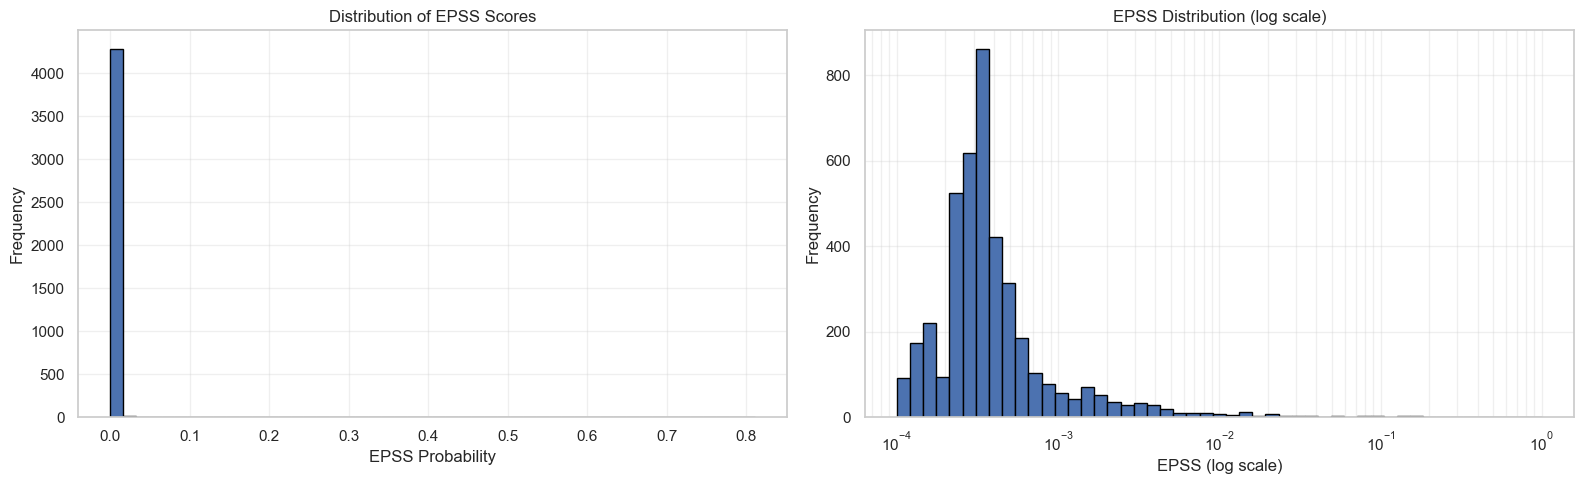

In [26]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))  # 1 riga, 2 colonne

# --- Grafico lineare ---
ax1.hist(epss, bins=50, edgecolor='black')
ax1.set_title("Distribution of EPSS Scores")
ax1.set_xlabel("EPSS Probability")
ax1.set_ylabel("Frequency")
ax1.grid(alpha=0.3)

# --- Grafico logaritmico ---
ax2.hist(epss, bins=np.logspace(-4, 0, 50), edgecolor='black')
ax2.set_xscale('log')
ax2.set_title("EPSS Distribution (log scale)")
ax2.set_xlabel("EPSS (log scale)")
ax2.set_ylabel("Frequency")
ax2.grid(alpha=0.3, which='both')

plt.tight_layout()
plt.show()


### Scatter Plot of CVSS vs EPSS

A scatter plot was created to compare the CVSS base scores with the corresponding EPSS probabilities.  

The majority of points are clustered near an EPSS probability of **0**, reflecting that most vulnerabilities in the dataset have a very low predicted likelihood of exploitation. Despite this, CVSS base scores are spread across the full range from low to high severity.  

The trendline shows a slight positive slope, indicating a weak correlation between CVSS and EPSS: vulnerabilities with higher CVSS scores tend to have slightly higher EPSS probabilities on average, but the relationship is not strong. Overall, the plot highlights that **CVSS severity does not directly predict exploitability**, and most vulnerabilities, even those with high CVSS scores, have minimal predicted risk of exploitation according to EPSS.

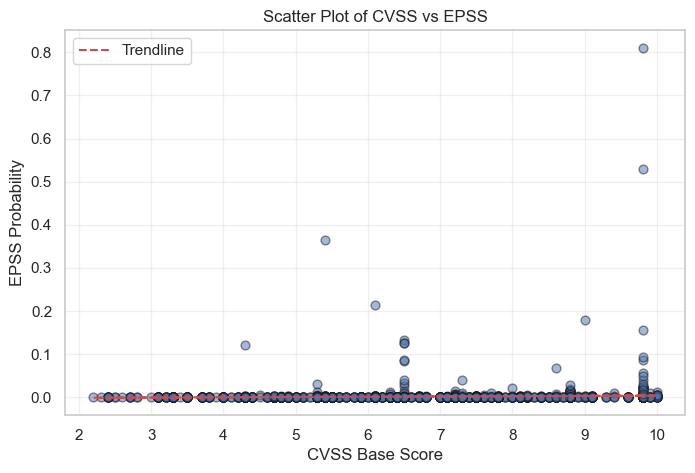

In [ ]:
# Filter only rows with valid CVSS and EPSS values
df_clean = df.dropna(subset=["cvss_baseScore", "epss_current"]).copy()
df_clean["cvss_baseScore"] = df_clean["cvss_baseScore"].astype(float)
df_clean["epss_current"] = df_clean["epss_current"].astype(float)

# Scatter plot
plt.figure(figsize=(8,5))
plt.scatter(df_clean["cvss_baseScore"], df_clean["epss_current"], alpha=0.5, edgecolors='k', s=40)
plt.xlabel("CVSS Base Score")
plt.ylabel("EPSS Probability")
plt.title("Scatter Plot of CVSS vs EPSS")
plt.grid(alpha=0.3)

# Add trendline
z = np.polyfit(df_clean["cvss_baseScore"], df_clean["epss_current"], 1)
p = np.poly1d(z)
plt.plot(df_clean["cvss_baseScore"], p(df_clean["cvss_baseScore"]), "r--", label="Trendline")
plt.legend()

plt.show()

# Extra

### Percentage of vulnerabilities in CISA KEV

In [28]:
print(
    f"Percentage of vulnerabilities in CISA KEV: {df["cve.cisaVulnerabilityName"].notna().sum() / len(df) * 100:.2f}%")


Percentage of vulnerabilities in CISA KEV: 0.32%


### Top Vendors by Number of Vulnerabilities

The top vulnerable CPEs are dominated by **Google Android**, **Microsoft Windows**, and **Apple macOS**. While most entries are operating systems, some critical applications like **Foxit PDF Editor** and **GitLab** also appear, highlighting the need to prioritize patching both OS and key software.


In [30]:
print("Most vulnerable vendors: \n\n",
      df["vulnerable_cpes"].explode().value_counts().head(20))

Most vulnerable vendors: 

 vulnerable_cpes
cpe:2.3:o:linux:linux_kernel:*:*:*:*:*:*:*:*                     2755
cpe:2.3:a:liferay:digital_experience_platform:*:*:*:*:*:*:*:*     120
cpe:2.3:o:linux:linux_kernel:6.17:rc1:*:*:*:*:*:*                 116
cpe:2.3:o:google:android:14.0:*:*:*:*:*:*:*                       110
cpe:2.3:o:apple:macos:*:*:*:*:*:*:*:*                             109
cpe:2.3:o:google:android:15.0:*:*:*:*:*:*:*                       108
cpe:2.3:o:google:android:13.0:*:*:*:*:*:*:*                        99
cpe:2.3:o:linux:linux_kernel:6.17:rc2:*:*:*:*:*:*                  93
cpe:2.3:o:debian:debian_linux:11.0:*:*:*:*:*:*:*                   69
cpe:2.3:o:microsoft:windows_server_2025:*:*:*:*:*:*:*:*            59
cpe:2.3:o:microsoft:windows_server_2022_23h2:*:*:*:*:*:*:*:*       57
cpe:2.3:o:microsoft:windows_server_2022:*:*:*:*:*:*:*:*            55
cpe:2.3:o:google:android:16.0:*:*:*:*:*:*:*                        54
cpe:2.3:a:liferay:liferay_portal:*:*:*:*:*:*:*

### Top 20 Most Frequent CWEs

The analysis of the CWE field reveals that **CWE-79 (Cross-site Scripting)** is the most frequent, with 715 occurrences, followed by **CWE-89 (SQL Injection)** with 432 occurrences and **CWE-74 (Injection)** with 294.  

Other frequent CWEs include **CWE-862 (Missing Authorization), CWE-352 (Cross-Site Request Forgery), and CWE-94 (Code Injection)**, indicating that injection and authorization issues are prevalent in the dataset.  

Overall, the top 20 CWEs represent the most common types of vulnerabilities, highlighting areas where security efforts should be focused.


In [31]:
print(df["cwe_list"].explode().value_counts().head(20))

cwe_list
CWE-79     714
CWE-89     434
CWE-74     294
CWE-476    238
CWE-401    212
CWE-862    203
CWE-416    164
CWE-352    162
CWE-94     134
CWE-284    121
CWE-125    114
CWE-787    108
CWE-77     100
CWE-78      90
CWE-434     87
CWE-918     75
CWE-22      73
CWE-20      67
CWE-200     66
CWE-502     63
Name: count, dtype: int64


# CVE selection


Filtering the CVEs with low EPSS (<1%)

In [33]:
df = df[df["epss_current"] < 0.01]


### EPSS–CVSS Ranking Code Summary

The code identifies and ranks high-risk vulnerabilities according to these CVSS exploitability metrics (that I chosen):

1. Computes the change in EPSS percentile over time (`percentile_diff`) to highlight vulnerabilities with increasing likelihood of exploitation.
2. Filters CVEs based on the following criteria ():  
   - `cvss_attackComplexity` is **LOW** or **MEDIUM**  
   - `cvss_attackVector` is **NETWORK** (It is much easier to consider a vulnerability that can be exploited via the network as important)
   - `cvss_privilegesRequired` is **NONE** (if it does not require privileges, it means that it is more dangerous and easier to exploit)
   - `cvss_userInteraction` is **NONE** (if it does not require user interaction, it means that there is no need for human intervention by staff or customers)  
   These conditions select vulnerabilities that are remotely exploitable without privileges or user interaction.
3. Sorts the filtered vulnerabilities by `cvss_baseScore` to prioritize the most severe.
4. Extracts the top 10 CVEs (`top10_cves`) as the final high-risk subset.


In [34]:
df['percentile_diff'] = df['percentile_current'] - df['percentile_old']
df.sort_values("percentile_diff", axis=0, ascending=False, inplace=True)

# Filter by updated criteria
df = df[
    (df["cvss_attackComplexity"].isin(["LOW", "MEDIUM"])) &  # LOW or MEDIUM
    (df["cvss_attackVector"] == "NETWORK") &                 # Network-based
    (df["cvss_privilegesRequired"] == "NONE") &              # No privileges
    (df["cvss_userInteraction"] == "NONE")                   # No user interaction
]

df = df.sort_values(by="cvss_baseScore", ascending=False)

top10_cves = df.iloc[:10]["cve.id"]
top10_cves



2341    CVE-2025-55113
3434    CVE-2025-59528
1355    CVE-2025-55730
1354    CVE-2025-55729
3994    CVE-2025-58384
1350    CVE-2025-55051
1115    CVE-2025-42944
1589    CVE-2025-58321
2369    CVE-2025-41243
3948    CVE-2025-60219
Name: cve.id, dtype: object

### Clean-up of merged EPSS data
This code keeps only the relevant columns after merging current and old EPSS scores, standardizing the CVE, EPS, and percentile columns, and dropping temporary or duplicate columns.


In [35]:
to_drop = ['cve_x',
           'cve_y',
           'epss_current',
           'percentile_current',
           'epss_old',
           'percentile_old',
           'percentile_diff']

df['cve'] = df['cve_x']
df['epss'] = df['epss_current']
df['percentile'] = df['percentile_current']
df.drop(columns=to_drop, inplace=True)


### My selection of CVEs

In [36]:
nickname = 'NoTimeToDie'


# TODO: put your selected IDs here
selected = top10_cves.tolist()
print(selected)
# selected = ['CVE-2025-41243', 'CVE-2025-59528', 'CVE-2025-59834', 'CVE-2025-10412', 'CVE-2025-9054', 'CVE-2025-9321', 'CVE-2025-59360', 'CVE-2025-59361', 'CVE-2025-59359', 'CVE-2025-57141']         

df[df['cve.id'].isin(selected)].to_csv(os.path.join(data_path, f'{nickname}.csv'))            

['CVE-2025-55113', 'CVE-2025-59528', 'CVE-2025-55730', 'CVE-2025-55729', 'CVE-2025-58384', 'CVE-2025-55051', 'CVE-2025-42944', 'CVE-2025-58321', 'CVE-2025-41243', 'CVE-2025-60219']


## Let's see the results

In [38]:
pd.read_csv('https://epss.empiricalsecurity.com/epss_scores-2026-01-06.csv.gz',
            compression='gzip', skiprows=1)

,cve,epss,percentile
0,CVE-1999-0001,0.01151,0.78023
1,CVE-1999-0002,0.09123,0.92407
2,CVE-1999-0003,0.89352,0.99521
3,CVE-1999-0004,0.03037,0.86253
4,CVE-1999-0005,0.13652,0.94017
...,...,...,...
309296,CVE-2026-21673,0.00012,0.01229
309297,CVE-2026-21674,0.00012,0.01253
309298,CVE-2026-21675,0.00060,0.18962
309299,CVE-2026-21676,0.00037,0.10709


Automatically builds a historical dataset of EPSS values for the selected CVEs.
For each check (I choose 3 days) in a given time range, it downloads the corresponding EPSS dataset, filters only the CVEs of interest, and stores their EPSS score, percentile, and observation date. 
The result is a time-series database that allows us to analyze how the exploitation probability of each selected vulnerability evolves over time.

In [49]:
from datetime import datetime, timedelta

# DataFrame that will contain the historical data
epss_log = pd.DataFrame(columns=["cve", "epss", "date"])

# First day you want to start tracking from
start_date = datetime(2025, 10, 1)

# Number of days to scan forward
num_days = 99

for n in range(0, num_days, 3):  # step = 3 days
    current_date = start_date + timedelta(days=n)
    date_str = current_date.date().isoformat()

    url = f"https://epss.empiricalsecurity.com/epss_scores-{date_str}.csv.gz"

    try:
        df = pd.read_csv(url, compression="gzip", skiprows=1)
    except:
        # If the file does not exist for that day, just skip it
        continue

    # Keep only the CVEs you selected
    df = df[df["cve"].isin(selected)]

    # Add the observation date
    df["date"] = current_date

    # Keep only the relevant columns
    df = df[["cve", "epss", "date"]]

    # Append to the historical log
    epss_log = pd.concat([epss_log, df], ignore_index=True)

# Save the historical dataset
os.makedirs("data", exist_ok=True)
epss_log.to_csv("data/epss_history.csv", index=False)

print("EPSS history saved to data/epss_history.csv")



/var/folders/_m/3_426zlx2m5gr6t4fq3zfh2w0000gn/T/ipykernel_5876/3205683991.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  epss_log = pd.concat([epss_log, df], ignore_index=True)


EPSS history saved to data/epss_history.csv


In [50]:
import pandas as pd

# Load historical EPSS data
epss_history = pd.read_csv("data/epss_history.csv")
epss_history["date"] = pd.to_datetime(epss_history["date"])

# List of CVEs
selected = epss_history["cve"].unique()

print("EPSS and percentile at the last available date:\n")

for cve in selected:
    # Filter for this CVE
    tmp = epss_history[epss_history["cve"] == cve]

    # Get the last observation
    last_row = tmp.sort_values("date").iloc[-1]

    print(f"{cve}: EPSS = {last_row['epss']:.4f}, Date = {last_row['date'].date()}")


EPSS and percentile at the last available date:

CVE-2025-41243: EPSS = 0.0700, Date = 2026-01-05
CVE-2025-42944: EPSS = 0.0002, Date = 2026-01-05
CVE-2025-55051: EPSS = 0.0006, Date = 2026-01-05
CVE-2025-55113: EPSS = 0.0006, Date = 2026-01-05
CVE-2025-55729: EPSS = 0.0042, Date = 2026-01-05
CVE-2025-55730: EPSS = 0.0042, Date = 2026-01-05
CVE-2025-58321: EPSS = 0.0070, Date = 2026-01-05
CVE-2025-58384: EPSS = 0.0058, Date = 2026-01-05
CVE-2025-59528: EPSS = 0.8316, Date = 2026-01-05
CVE-2025-60219: EPSS = 0.0006, Date = 2026-01-05


Visualizes this historical data.
By plotting EPSS (and optionally the percentile) against time for each CVE, it becomes possible to observe trends, such as rapid increases in exploitation likelihood or stable low-risk behavior. This directly supports the evaluation of whether the initial predictions were correct.

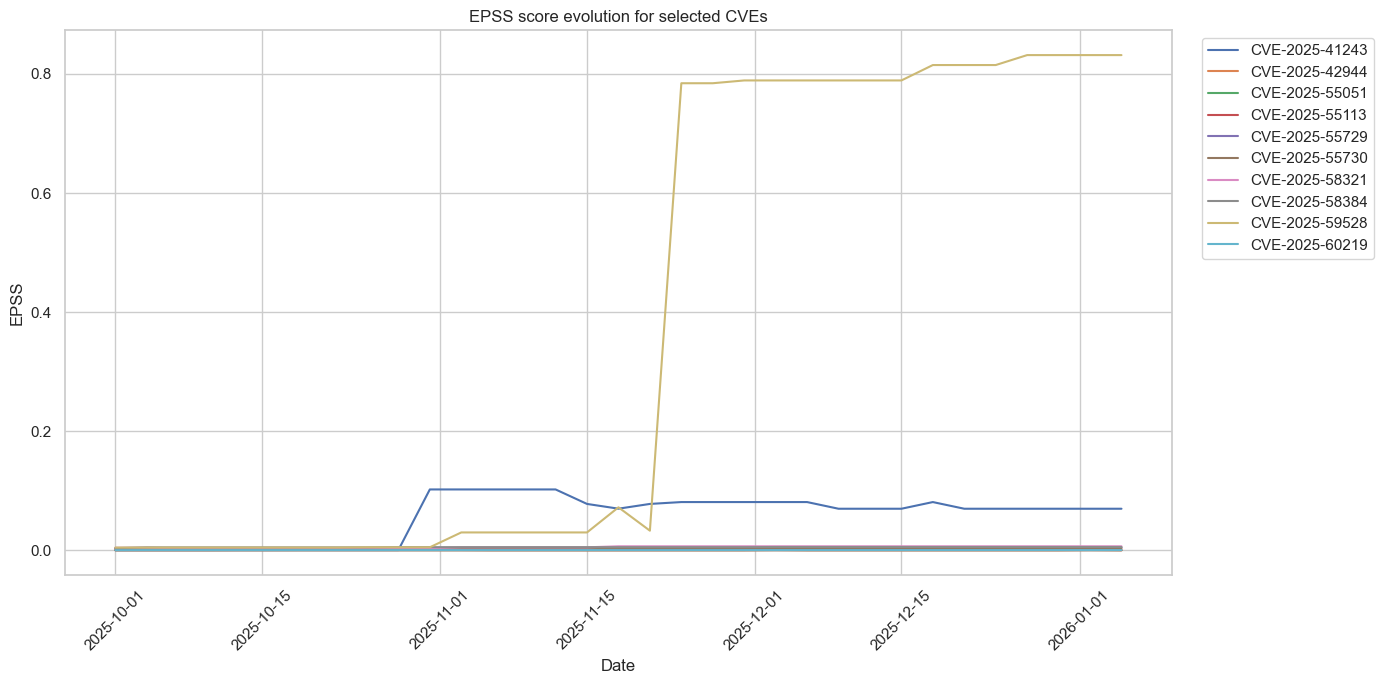

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Load historical EPSS data
epss_history = pd.read_csv("data/epss_history.csv")
epss_history["date"] = pd.to_datetime(epss_history["date"])

# List of CVEs to plot
selected = epss_history["cve"].unique()

plt.figure(figsize=(14, 7))

for cve in selected:
    tmp = epss_history[epss_history["cve"] == cve]
    plt.plot(tmp["date"], tmp["epss"], label=cve)

plt.title("EPSS score evolution for selected CVEs")
plt.xlabel("Date")
plt.ylabel("EPSS")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


## Conclusion
Most of the selected CVEs remained at an EPSS of 0, indicating no active exploitation despite their high theoretical risk. However, two CVEs showed significant increases, one reaching 0.0700 and the other 0.8316, validating the selection criteria in some cases. This demonstrates that while predictive metrics like CVSS-based exploitability are useful, continuous monitoring of EPSS is necessary to identify real-world threats.

### Let's see CVE-2025-59528: EPSS = 0.8316, Last date = 2026-01-07
Flowise is a drag & drop user interface to build a customized large language model flow. In version 3.0.5, Flowise is vulnerable to remote code execution. The CustomMCP node allows users to input configuration settings for connecting to an external MCP server. This node parses the user-provided mcpServerConfig string to build the MCP server configuration. However, during this process, it executes JavaScript code without any security validation. Specifically, inside the convertToValidJSONString function, user input is directly passed to the Function() constructor, which evaluates and executes the input as JavaScript code. Since this runs with full Node.js runtime privileges, it can access dangerous modules such as child_process and fs. ***This issue has been patched in version 3.0.6.***

CWE-94	Improper Control of Generation of Code ('Code Injection')

Sources: https://nvd.nist.gov/vuln/detail/cve-2025-59528





